## Load models and data

In [76]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
import random
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb

# import Models_MNIST as mds
import Models_MNIST_v2 as mds

# Hyper Parameters
EPOCH = 50
BATCH_SIZE = 256
DOWNLOAD_MNIST = False
m1 = 64
m2 = 128
m3 = 100
cudaopt = True

EPS = 1e-4

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# LIMITING TRAINING DATA
Ntrain = int(60e3)
train_set = np.random.permutation(60000)[0:Ntrain]
train_data.train_data = train_data.train_data[torch.LongTensor(train_set),:,:]
train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

## Characterise Rho parameter

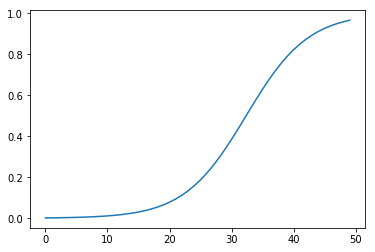

In [77]:
x = np.linspace(1,EPOCH,EPOCH)
Rhos = 1/(1+np.exp(-(x- EPOCH*6/9 )*.2))
plt.plot(Rhos)

## Define functions to test hypothesis

In [78]:
def test_activations(model, x, labels):
    # Initialise dics to contain sorted data
    label_bin_data = {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[]} # Dictionary of lists of tensors
    data_by_class = {} # Dictionary of tensors
    encoded_by_class = {} # Dictionary of tensors
    scores_by_class = {} # Dictionary of lists
    sorted_labels = np.empty(labels.shape[0])
    index = 0
    
    activations_count1 = {}
    activations_count2 = {}
    activations_count3 = {}
    
    # Sort data by its label class into a dictionary of lists which contain the data point tensors
    for i in range(labels.shape[0]):
        label_bin_data[str(int(labels[i].item()))].append(x[i,:,:,:])
    # Turn each list of tensors in the dictionary into a tensor
    first = True
    for key, tensor_list in label_bin_data.items():
        if len(label_bin_data[key]) > 0:
            sorted_labels[index:index+len(label_bin_data[key])] = int(key)*np.ones(len(label_bin_data[key]))
            index = index+len(label_bin_data[key])
            data_by_class[key] = torch.stack(label_bin_data[key], dim=0)#.type(torch.cuda.FloatTensor)
            encoded_by_class[key], scores_by_class[key], gamma1, gamma2, gamma3 = model.forward(data_by_class[key])
            activations_count1[key] = count_activations(gamma1, m1)
            activations_count2[key] = count_activations(gamma2, m2)
            activations_count3[key] = count_activations(gamma3, m3)
            if first == True:
                scores = scores_by_class[key]
                first = False
            else:
                scores = torch.cat((scores, scores_by_class[key]), 0)
    sorted_labels = torch.from_numpy(sorted_labels).type(torch.cuda.LongTensor)
    return encoded_by_class, scores, sorted_labels, activations_count1, activations_count2, activations_count3

def count_activations(gamma, numb_nodes, tol=1e-4):
    gamma_dims = list(gamma.shape)
    gamma[gamma<tol]=0
    gamma[gamma>=tol]=1
    activations = np.sum(gamma, axis=3)
    activations = np.sum(activations, axis=2)
    activations = np.sum(activations, axis=0)
    return activations

## Train baseline model

In [79]:
Loss_test_0 = np.zeros((EPOCH,))
Acc_test_0 = np.zeros((EPOCH,))
Acc_train_0 = np.zeros((EPOCH,))

# Include only if want to produce activation histogram
activations_count1_nn = {"0": np.zeros(m1), "1":np.zeros(m1), "2":np.zeros(m1), "3":np.zeros(m1), "4":np.zeros(m1), "5":np.zeros(m1), "6":np.zeros(m1), "7":np.zeros(m1), "8":np.zeros(m1), "9":np.zeros(m1)}
activations_count2_nn = {"0": np.zeros(m2), "1":np.zeros(m2), "2":np.zeros(m2), "3":np.zeros(m2), "4":np.zeros(m2), "5":np.zeros(m2), "6":np.zeros(m2), "7":np.zeros(m2), "8":np.zeros(m2), "9":np.zeros(m2)}
activations_count3_nn = {"0": np.zeros(m3), "1":np.zeros(m3), "2":np.zeros(m3), "3":np.zeros(m3), "4":np.zeros(m3), "5":np.zeros(m3), "6":np.zeros(m3), "7":np.zeros(m3), "8":np.zeros(m3), "9":np.zeros(m3)}


print('\n\t\t\t\t\tTraining Baseline\n')
    
model_0 = mds.ML_ISTA_NET(m1,m2,m3)
if cudaopt:
    model_0.cuda()

optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_0.train()
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
            
#         gamma, scores= model_0(b_x) # Use for Models_MNIST
        gamma, scores,_,_,_ = model_0(b_x) # Use for Models_MNIST_v2
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(b_y.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
    Acc_train_0[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))
    
    # testing
    model_0.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
            
#         gamma, scores= model_0(b_x) # Use for Models_MNIST
#         gamma, scores,_,_,_ = model_0(b_x) # Use for Models_MNIST_v2, no activation historgram
        encoded_by_class, scores, sorted_labels, activations1, activations2, activations3 = test_activations(model_0, b_x, b_y) # Use for Models_MNIST_v2 with activation histogram
        for key, tensor_list in activations1.items():
            activations_count1_nn[key] += activations1[key]
            activations_count2_nn[key] += activations2[key]
            activations_count3_nn[key] += activations3[key]
                
        test_loss += F.nll_loss(scores, sorted_labels, size_average=False).data[0] # b_y for sorted_labels
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(sorted_labels.data.view_as(pred)).long().cpu().sum() # b_y for sorted_labels
        
    test_loss /= len(test_loader.dataset)
    Loss_test_0[epoch] = test_loss
    Acc_test_0[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
torch.save(model_0.state_dict(), 'cnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Baseline



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
- |  #                                              | 100 Elapsed Time: 0:07:20

## Train joint model

In [80]:
importlib.reload(mds)

Loss_test_jista_r = np.zeros((EPOCH,))
Acc_test_jista_r = np.zeros((EPOCH,))
Acc_train_jista_r = np.zeros((EPOCH,))

# Include only if want to produce activation histogram
activations_count1_jnn = {"0": np.zeros(m1), "1":np.zeros(m1), "2":np.zeros(m1), "3":np.zeros(m1), "4":np.zeros(m1), "5":np.zeros(m1), "6":np.zeros(m1), "7":np.zeros(m1), "8":np.zeros(m1), "9":np.zeros(m1)}
activations_count2_jnn = {"0": np.zeros(m2), "1":np.zeros(m2), "2":np.zeros(m2), "3":np.zeros(m2), "4":np.zeros(m2), "5":np.zeros(m2), "6":np.zeros(m2), "7":np.zeros(m2), "8":np.zeros(m2), "9":np.zeros(m2)}
activations_count3_jnn = {"0": np.zeros(m3), "1":np.zeros(m3), "2":np.zeros(m3), "3":np.zeros(m3), "4":np.zeros(m3), "5":np.zeros(m3), "6":np.zeros(m3), "7":np.zeros(m3), "8":np.zeros(m3), "9":np.zeros(m3)}


print('\n\t\t\t\t\tTraining ML-JISTA \n')

T = 0  # number of unfoldings/iterations of ml-ista

model_jnn = mds.ML_JISTA_NET(m1,m2,m3)
if cudaopt:
    model_jnn.cuda()

optimizer = torch.optim.Adam(model_jnn.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
#     print("Epoch: " + str(int(epoch)))
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_jnn.train()
    
    RHO =  float(Rhos[epoch])
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores, sorted_labels = model_jnn.joint_train(b_x, b_y, T, RHO)
        sorted_labels = sorted_labels.type(torch.cuda.LongTensor)
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(sorted_labels.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, sorted_labels)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
    Acc_train_jista_r[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))    
        
    # testing
    model_jnn.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
#         gamma, scores = model_jnn.forward(b_x,T,RHO)
#         gamma, scores,_,_,_ = model_jnn.forward(b_x,T,RHO)
    
        encoded_by_class, scores, sorted_labels, activations1, activations2, activations3 = test_activations(model_jnn, b_x, b_y) # Use for Models_MNIST_v2 with activation histogram
        for key, tensor_list in activations1.items():
            activations_count1_jnn[key] += activations1[key]
            activations_count2_jnn[key] += activations2[key]
            activations_count3_jnn[key] += activations3[key]
    
        test_loss += F.nll_loss(scores, sorted_labels, size_average=False).data[0] # b_y for sorted_labels
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(sorted_labels.data.view_as(pred)).long().cpu().sum() # b_y for sorted_labels
        
    test_loss /= len(test_loader.dataset)
    Loss_test_jista_r[epoch] = test_loss
    Acc_test_jista_r[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
torch.save(model_jnn.state_dict(), 'mljista_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training ML-JISTA 



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:68: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
- |    #                                            | 100 Elapsed Time: 0:10:56

## Plot train and test accuracy

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


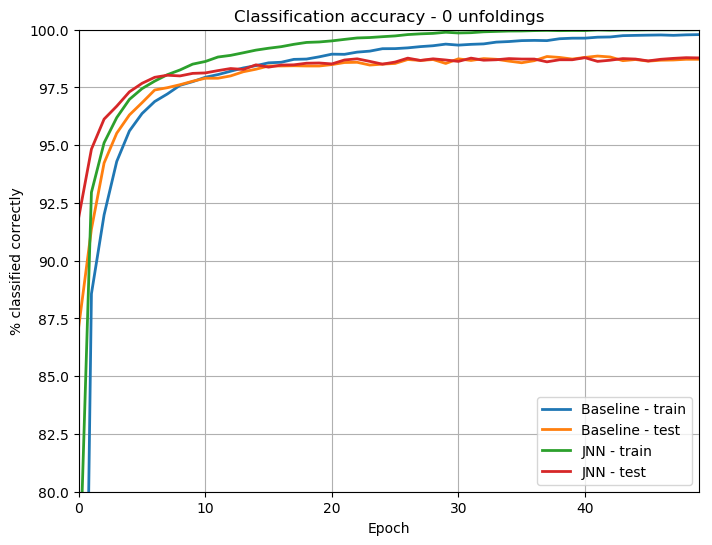

In [84]:
fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(Acc_train_0, linewidth = 2,label='Baseline - train')
plt.plot(Acc_test_0, linewidth = 2,label='Baseline - test')
plt.plot(Acc_train_jista_r, linewidth = 2,label = 'JNN - train')
plt.plot(Acc_test_jista_r, linewidth = 2,label = 'JNN - test')

plt.grid('on')
plt.title('Classification accuracy - 0 unfoldings')
plt.legend()
plt.axis([0, EPOCH-1, 80, 100])
plt.xlabel('Epoch')
plt.ylabel('% classified correctly')
plt.show()

## Visualise filter activations

torch.Size([100, 128, 4, 4])
torch.Size([100, 64, 12, 12])
torch.Size([100, 1, 28, 28])
torch.Size([100, 128, 4, 4])
torch.Size([100, 64, 12, 12])
torch.Size([100, 1, 28, 28])


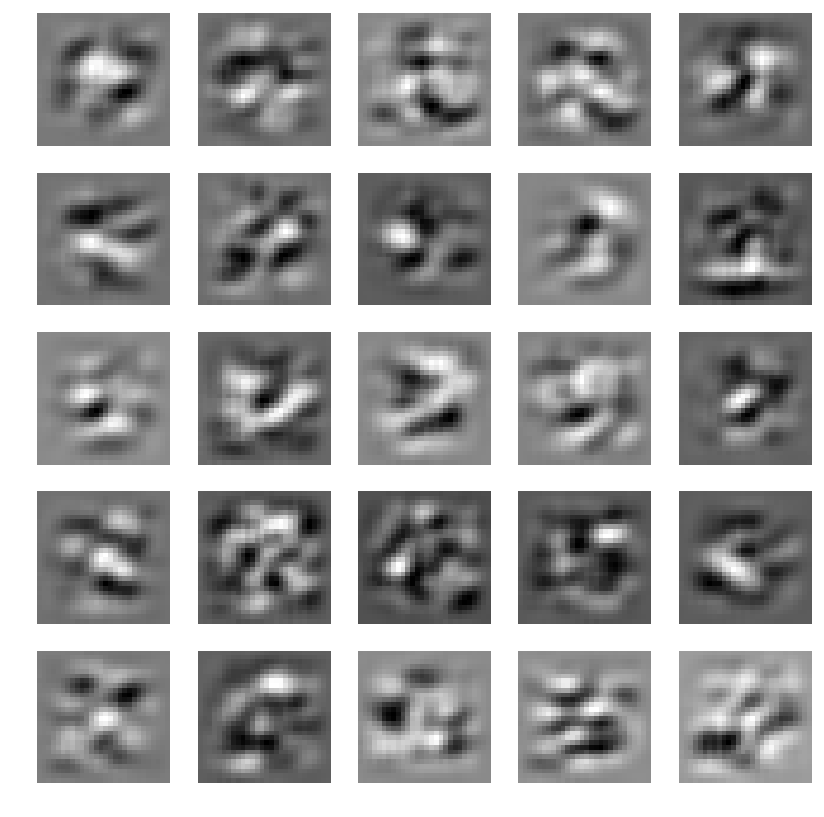

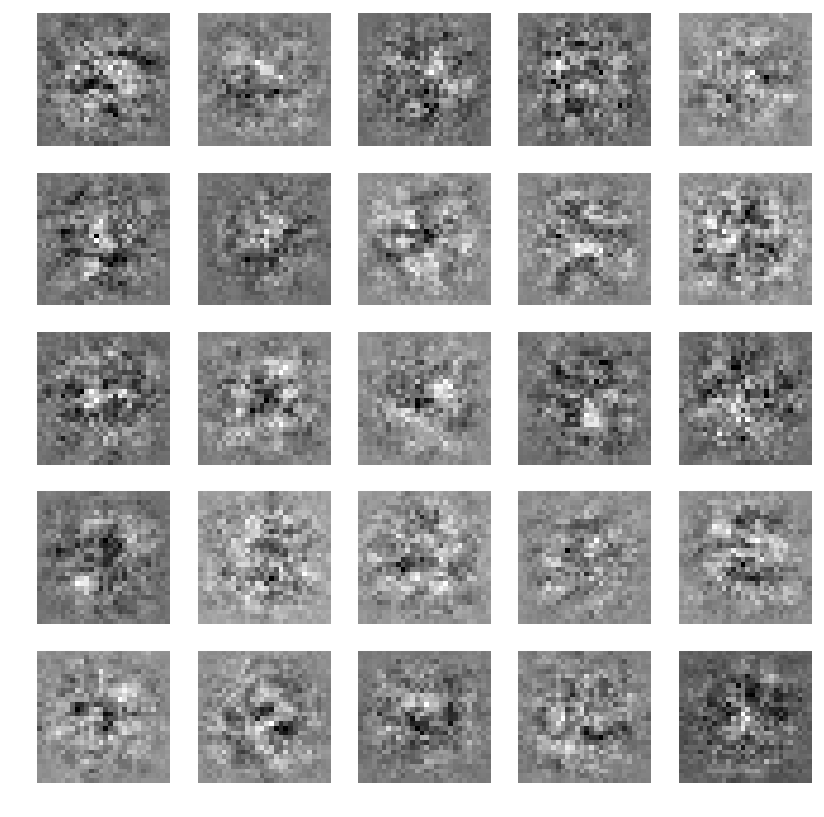

In [82]:
cols = 5
rows = 5
indices = random.sample(range(m3), cols*rows)

dict1 = model_0.W3
atom1_dim = dict1.shape[3]
print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_0.W2, stride=model_0.strd1, dilation=1)
atom2_dim = dict2.shape[3]
print(dict2.shape)

dict3_0 = F.conv_transpose2d(dict2, model_0.W1, stride=model_0.strd2, dilation=1)
atom3_dim = dict3_0.shape[3]
print(dict3_0.shape)

dict1 = model_jnn.W3
atom1_dim = dict1.shape[3]
print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_jnn.W2, stride=model_jnn.strd1, dilation=1)
atom2_dim = dict2.shape[3]
print(dict2.shape)

dict3_jnn = F.conv_transpose2d(dict2, model_jnn.W1, stride=model_jnn.strd2, dilation=1)
atom3_dim = dict3_jnn.shape[3]
print(dict3_jnn.shape)


idx = 1

plt.figure(2, figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        plt.imshow(np.reshape(dict3_0.cpu().data.numpy()[idx-1], (atom3_dim, atom3_dim)), cmap='gray')
        plt.axis('off')
        idx+=1
        
idx = 1

plt.figure(1, figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        plt.imshow(np.reshape(dict3_jnn.cpu().data.numpy()[idx-1], (atom3_dim, atom3_dim)), cmap='gray')
        plt.axis('off')
        idx+=1

plt.show()

plt.show()

## Histograms of activations

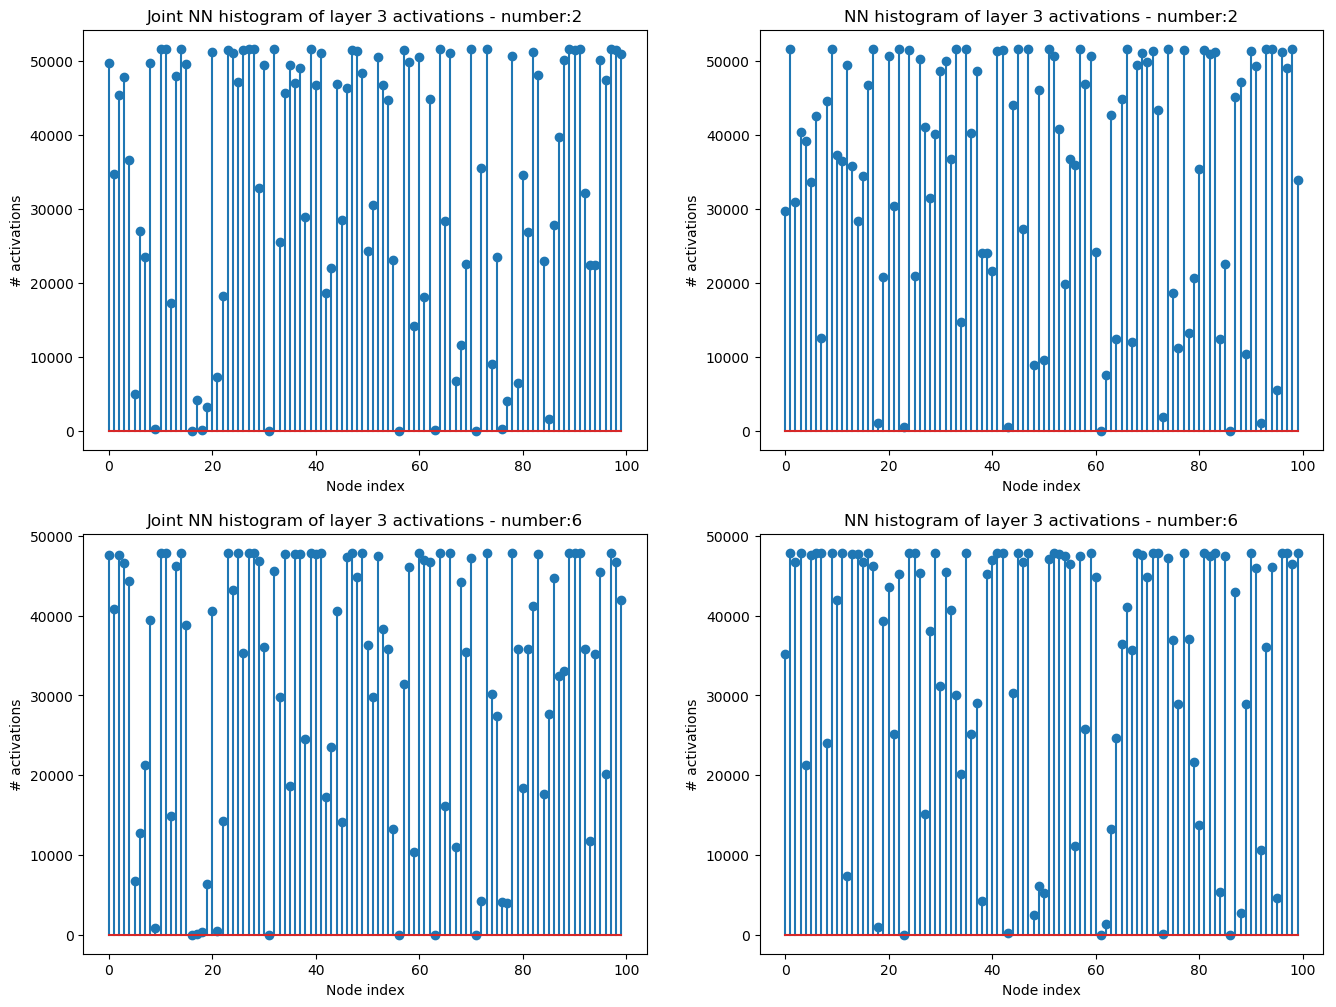

In [83]:
idx1 = 2
idx2 = 6

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.stem(np.arange(m3), activations_count3_jnn[str(idx1)])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,2)
plt.stem(np.arange(m3), activations_count3_nn[str(idx1)])
plt.title('NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,3)
plt.stem(np.arange(m3), activations_count3_jnn[str(idx2)])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,4)
plt.stem(np.arange(m3), activations_count3_nn[str(idx2)])
plt.title('NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.show()